In [1]:
#Used to find subsets of lists
import itertools
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

In [2]:
##Helper functions

#Updates endogenous variables (V) given a certain state X,W
#i.e. sets to True/False given X or W
def V_given_set(V,X_or_W,indices):
    updated_V = V.copy()
    var_seen = 0
    for i in range(len(V)):
        if i in indices:
            updated_V[i] = X_or_W[var_seen]
            var_seen += 1
    return updated_V
    
#Creates a list of all subsets (cardinality >= 1) of a given lst
#Used https://bit.ly/2YVGYxt
def subsets_finder(indices):
    #indices corresp. to elem of some lst opposed to using indices corresp to V.
    updated_idx = [i for i in range(len(indices))]
    return [list(subset) for i in range(0, len(updated_idx)+1)
            for subset in itertools.combinations(updated_idx, i)]

#returns list of all possible splits(take indices finds all )
#Used: https://bit.ly/2KfTeFk
def partitions(indices):
    subsets = [v for a in range(len(indices)) for v in itertools.combinations(indices, a)]
    comb = []
    for i in range(len(subsets)//2 + 1):
        comb.append((list(itertools.chain(subsets[i])), [e for e in indices if e not in subsets[i]]))
    return comb
    
#Given certain indices, updates lst[i] = not lst[i] for i in indices
def negate_var(lst,indices):
    return_lst = lst.copy()
    for i in range(len(lst)):
        if(i in indices):
            return_lst[i] = not lst[i]
    return return_lst

#Extracts given elements from X using t
def extract_X(X,t):
    return_lst = []
    for i in t:
        return_lst.append(X[i])
    return return_lst


#Created a class of original H.P defn of Causality
class Causal_Model:
    #U,V,F are assumed to be lists for simplicity sake
    #Assumed that final var = outcome (e.g. last elem of V = Forest Fire)
    #U,V are boolean values corresp. to some list of var
    #F is a list of pointers to functions (e.g. def foo())
    def __init__(self, U, V, R, F):
        self.exogenous_var = U
        self.endogenous_var = V
        self.var_range = R
        self.function = F
        self.signature = (U,V,R)
        self.model = (self.signature,F)
    
    
    
    # For the following, I assume that this can be used to check causality if an outcome did not occur(?)
    
    #AC1 of defn, checks if outcome = function for given X
    #outcome_val refers to desired outcome
    def ac1_check(self,X,X_indices,outcome_function,outcome_val):
        V = V_given_set(self.endogenous_var,X,X_indices)
        outcome_given_X = outcome_function(self.exogenous_var,V)
        return outcome_given_X == outcome_val

    #AC2(a) checks the but-for clause, i.e changing X would lead to opposite outcome
    #2005 paper says W->w' but modified defn. paper says W->w, func is using the latter 
    #This function finds the correct W, and calls ac2_b
    def ac2_a_check(self,Z,Z_indices,X,X_indices,W,W_indices,outcome_function,outcome_val):
        V = V_given_set(self.endogenous_var,Z,Z_indices)
        V = V_given_set(V,W,W_indices)
        x_prime = [not i for i in X]
        V_given_x_prime = V_given_set(V,x_prime,X_indices)
        outcome = outcome_function(self.exogenous_var,V_given_x_prime)
        #Checks if initial W is optimal and returns
        if outcome_val != outcome:
            return True
        else:
            return False
    
    
    #Checks AC2(b) of the defn
    #Checks that outcome holds for all subsets of Z (Z') if Z' is set to original value
    def ac2_b_check(self,Z,Z_indices,X,X_indices,W,W_indices,outcome_function, outcome_val):
        V = self.endogenous_var
        V_fixed_W = V_given_set(V,W,W_indices)
        subsets_of_Z = subsets_finder(Z_indices)
        orig_Z = [V[i] for i in Z_indices]
        curr_Z = Z.copy()
        for subset in subsets_of_Z:
            for i in subset:
                curr_Z[i] = orig_Z[i]
            curr_V = V_given_set(V_fixed_W,curr_Z,Z_indices)
            outcome = outcome_function(self.exogenous_var,curr_V)
            if(outcome_val != outcome):
                return False
            else:
                curr_Z = Z.copy()
        return True
    
    #Checks AC2(b^u) of the defn
    #Checks that outcome holds for all subsets of W (W') and Z(Z') if W',Z' is set to original value
    def ac2_b_u_check(self,Z,Z_indices,X,X_indices,W,W_indices,outcome_function, outcome_val):
        V = self.endogenous_var
        subsets_of_Z = subsets_finder(Z_indices)
        subsets_of_W = subsets_finder(W_indices)
        orig_Z = [V[i] for i in Z_indices]
        curr_Z = Z.copy()
        orig_W = [V[i] for i in W_indices]
        curr_W = W.copy()
        for sub_Z in subsets_of_Z:
            for i in sub_Z:
                curr_Z[i] = orig_Z[i]
            for sub_W in subsets_of_W:
                for i in sub_W:
                    curr_W[i] = orig_W[i]
                curr_V = V_given_set(V,curr_Z,Z_indices)
                curr_V = V_given_set(curr_V,curr_W,W_indices)
                outcome = outcome_function(self.exogenous_var,curr_V)
                curr_W = W.copy()
                if(outcome_val != outcome):
                    return False
            curr_Z = Z.copy()
        return True
    
    #Returns true if ac2_a^m is satisfied
    #Also gives the coresp. W,W_indices that satisfy the defn
    #Output: [W, W_indices, T/F]
    def ac2_m_check(self,X,X_indices,outcome_function,outcome_val):
        V = self.endogenous_var
        V_indices_excluding_X = [i for i in range(len(V)) if i not in X_indices]
        potential_W_indices = subsets_finder(V_indices_excluding_X)
        subsets_X = subsets_finder(X_indices)
        for sub in subsets_X:
            curr_X = negate_var(X,sub)
            curr_V = V_given_set(V,curr_X,X_indices)
            for w_indices in potential_W_indices:
                curr_W = [V[i] for i in w_indices]
                curr_outcome = outcome_function(self.exogenous_var,curr_V)
                if(curr_outcome != outcome_val):
                    return[curr_W,w_indices,True]
        
        return [None,None,False]
    
    def ac2_check_given_Z_W(self,Z,Z_indices,X,X_indices,W,W_indices,outcome_function,outcome_val):
        ac2_a = self.ac2_a_check(Z,Z_indices,X,X_indices,W,W_indices,outcome_function,outcome_val)
        ac2_b = self.ac2_b_check(Z,Z_indices,X,X_indices,W,W_indices,outcome_function,outcome_val)
        if(ac2_a and ac2_b):
            return True
        else:
            return False
        
    def ac2_u_check_given_Z_W(self,Z,Z_indices,X,X_indices,W,W_indices,outcome_function,outcome_val):
        ac2_a = self.ac2_a_check(Z,Z_indices,X,X_indices,W,W_indices,outcome_function,outcome_val)
        ac2_b = self.ac2_b_u_check(Z,Z_indices,X,X_indices,W,W_indices,outcome_function,outcome_val)
        if(ac2_a and ac2_b):
            return True
        else:
            return False
    
    
    #Goes through all partitions of V (partitions named Z,W) and returns the first Z,W to satisfy
    #defn is an int(0,1) corresp to (original def, updated defn ('05))
    def Z_and_W_search(self,X,X_indices,outcome_function,outcome_val,defn):
        Z = X.copy()
        Z_indices = X_indices.copy()
        Useable_V_indices = [i for i in range(len(self.endogenous_var)) if i not in X_indices]
        splits = partitions(Useable_V_indices)
        for partition in splits:
            curr_Z_indices_no_X = partition[0]
            curr_W_indices = partition[1]
            curr_Z_indices = Z_indices + curr_Z_indices_no_X
            curr_Z = [self.endogenous_var[i] for i in curr_Z_indices]
            curr_W = [self.endogenous_var[i] for i in curr_W_indices]
            ac2_check = self.ac2_check_given_Z_W(curr_Z,curr_Z_indices,X,X_indices,
                                                 curr_W,curr_W_indices,outcome_function,outcome_val)
            if(ac2_check):
                return [curr_W,curr_W_indices,True]
            else:
                curr_Z_no_X = [self.endogenous_var[i] for i in curr_Z_indices_no_X]
                subsets_of_curr_Z_no_X = subsets_finder(curr_Z_indices_no_X)
                subsets_of_curr_W = subsets_finder(curr_W_indices)
                for sub_z in subsets_of_curr_Z_no_X:
                    updated_Z = X + negate_var(curr_Z_no_X,sub_z)
                    for sub_w in subsets_of_curr_W:
                        updated_W = negate_var(curr_W,sub_w)
                        ac2_check = self.ac2_check_given_Z_W(updated_Z,curr_Z_indices,X,X_indices,updated_W,
                                                             curr_W_indices,outcome_function,outcome_val)
                        ac2_u_check = self.ac2_u_check_given_Z_W(updated_Z,curr_Z_indices,X,X_indices,updated_W,
                                                             curr_W_indices,outcome_function,outcome_val)
                        if((defn == 0 and ac2_check) or (defn == 1 and ac2_u_check)):
                            return [updated_W,curr_W_indices,True]
        return [None,None,False]
                    
    
    
    
    
    #Checks that X is minimal by iterating over all subsets
    def ac3_check(self,X,X_indices,outcome_function,outcome_val):
        if(len(X) <= 1):
            return True
        
        subsets_of_X = subsets_finder(X_indices)
        for i in subsets_of_X:
            updated_X = extract_X(X,i)
            W_indices = [j for j in range(len(self.endogenous_var)) if j not in i]
            W = [self.endogenous_var[k] for k in W_indices]
            ac2_check = self.ac2_a_check(updated_X,i,updated_X,i,W,W_indices,outcome_function,outcome_val)
            if(ac2_check):
                return False
            
        return True
    #Fail checking
    def wrong_check(self,ac_1,ac_2,ac_3):
        if (not ac_1):
            print("(False b/c of AC1)")
        if(not ac_2):
            print("(False b/c of AC2)")
        if(not ac_3):
            print("(False b/c of AC3)")
    
    #Returns true if X satisfies HP defn, False o.w.
    def causality_check(self,X,X_indices,outcome_val,outcome_func):
        ac_1 = self.ac1_check(X,X_indices,outcome_func,outcome_val)
        ac_2 = self.Z_and_W_search(X,X_indices,outcome_func,outcome_val,0)[2]
        ac_3 = self.ac3_check(X,X_indices,outcome_func,outcome_val)
        self.wrong_check(ac_1,ac_2,ac_3)
        return ac_1 and ac_2 and ac_3
    
    #Returns true if X satisfied the modified defn. (using ac1,ac2(a),ac2(b^u), ac3 - Halpern & Pearl 2005)
    def updated_causality_check(self,X,X_indices,outcome_val,outcome_func):
        ac_1 = self.ac1_check(X,X_indices,outcome_func,outcome_val)
        ac_2 = self.Z_and_W_search(X,X_indices,outcome_func,outcome_val,1)[2]
        ac_3 = self.ac3_check(X,X_indices,outcome_func,outcome_val)
        self.wrong_check(ac_1,ac_2,ac_3)
        return ac_1 and ac_2 and ac_3
    
    #Returns true if X satisfies modified defn of Halpern & Pearl 2014 (ac1, ac2_m, ac3)
    def modified_causality_check(self,X,X_indices,outcome_val,outcome_func):
        ac_1 = self.ac1_check(X,X_indices,outcome_func,outcome_val)
        ac_2 = self.ac2_m_check(X,X_indices,outcome_func,outcome_val)[2]
        ac_3 = self.ac3_check(X,X_indices,outcome_func,outcome_val)
        self.wrong_check(ac_1,ac_2,ac_3)
        return ac_1 and ac_2 and ac_3
    
    #Returns "responsibility" as per Chockler & Halpern (2004)
    # i.e. finds the number of changes needed to make the outcome depend on X
    #This currently uses the first available W, as o.w. I can't finish running Electoral college example
    #TB-FIXED
    def responsibility(self,X,X_indices,outcome_val,outcome_func):
        if(self.causality_check(X,X_indices,outcome_val,outcome_func)):
            if(outcome_func(self.exogenous_var,V_given_set(self.endogenous_var,X,X_indices))!=outcome_val):
                return 1
            else:
                W,W_indices = self.Z_and_W_search(X,X_indices,outcome_func,outcome_val,0)[0:2]
                orig_W = [self.endogenous_var[i] for i in W_indices]
                num_changes = sum([1 for i in range(len(W)) if W[i] != orig_W[i]])
                return 1 / (num_changes + 1)
        else:
            return 0
        
    #num_outcome_var denote var in V which are not part of structural eqn. (e.g. Forest Fire)
    #Fixes X ("Causal" variable) to be X' (i.e. not x for x in X) in the model
    # Goes through each possible scenario of variable assignments in V (assuming T/F)
    # Returns num_scenarios_where_outcome_changed_from_orig / num_scenarios
    #Assumes X is only T/F valued
    def influence(self,X,X_indices,num_outcome_var,outcome_func):
        end_idx = (-1)*num_outcome_var
        V = self.endogenous_var
        V_negated_X = negate_var(V,X_indices)
        subsets_V_negated_X = subsets_finder([i for i in range(len(V_negated_X[0:end_idx]))])
        if(len(subsets_V_negated_X) == 0):
            return 0
        
        outcome_change_ct = 0
        subsets_seen = []
        for sub in subsets_V_negated_X:
            sub_no_X = [i for i in sub if i not in X_indices]
            if(sub_no_X in subsets_seen):
                continue
            
            else:
                subsets_seen.append(sub_no_X)
                V_pos_prime = negate_var(V[0:end_idx],sub_no_X)
                outcome_pos_prime = outcome_func(self.exogenous_var,V_pos_prime)
                V_neg_prime = negate_var(V_negated_X[0:end_idx],sub_no_X)
                outcome_neg_prime = outcome_func(self.exogenous_var,V_neg_prime)
                if(outcome_pos_prime != outcome_neg_prime):
                    outcome_change_ct += 1
        return outcome_change_ct / len(subsets_seen)
    
    #Adj responsibility = influence*responsibility
    def adj_responsibility(self,X,X_indices,num_outcome_var,outcome_val,outcome_func):
        inf = self.influence(X,X_indices,num_outcome_var,outcome_func)
        res = self.responsibility(X,X_indices,outcome_val,outcome_func)
        return inf*res
    
    #Adj responsibility_2 = sum of influence of var in W that change
    def adj_responsibility_2(self,X,X_indices,num_outcome_var,outcome_val,outcome_func):
        W,W_indices = self.Z_and_W_search(X,X_indices,outcome_func,outcome_val,0)[0:2]
        if(W is None):
            return None
        orig_W = [self.endogenous_var[i] for i in W_indices]
        changed_W_indices = [W_indices[i] for i in range(len(W_indices)) if W[i] != orig_W[i]]
        inf_changed_W = [self.influence([W[i]],[i],
                                        num_outcome_var,outcome_func)
                        for i in changed_W_indices]
        return sum(inf_changed_W)
        
    #Influence function but only samples n states (assuming n >= 1)
    #Saves time as inf function is exponential ; mc = Monte Carlo method to sample from uniform [0,1]
    def mc_inf_sample(self,X,X_indices,num_outcome_var,outcome_func,n):
        if(n <= 0):
            raise ValueError
        V = self.endogenous_var
        v_idx_to_change = [i for i in range(len(V[0:(-1)*num_outcome_var])) if i not in X_indices]
        outcome_change_ct = 0
        seen = []
        for i in range(n):
            random_vec = np.random.randint(2,size = len(v_idx_to_change))
            changeable_var_vec = [True if random_vec[i] == 1 else False for i in range(len(random_vec))]
            curr_V_pos = V_given_set(V,changeable_var_vec,v_idx_to_change)
            curr_V_neg = negate_var(curr_V_pos,X_indices)
            outcome_pos = outcome_func(self.exogenous_var,curr_V_pos)
            outcome_neg = outcome_func(self.exogenous_var,curr_V_neg)
            if(outcome_pos != outcome_neg):
                outcome_change_ct += 1

        return outcome_change_ct / n

## Testing
### Using examples from 2005 HP paper

### Example 2.1: Forest Fire (F) caused by either Lightning (L) or Match Lit (ML) 

In [3]:
#Initializes U to True for random exogen. var (val/var not important)
# V = True for all
#R is trivially set to 0 or 1
# Index[0] = L ; Index[1] = ML ; Index[2] = F
U = [True,True,True]
V = [True,True,True]
R = [(False,True),(False,True),(False,True)]
def forest_fire(U,V):
    return V[0] or V[1]
F_f = forest_fire
F = [None, None, F_f]
FF_model = Causal_Model(U,V,R,F)

In [4]:
X = [True]
X_index = [0]
print("Testing Casuality of Lightning (Correct Val = True):")
print(FF_model.causality_check(X,X_index,True,F_f))
print("\nTesting Updated Casuality of Lightning (Correct Val = True):")
print(FF_model.updated_causality_check(X,X_index,True,F_f))
print("\nTesting Modified Casuality of Lightning (Correct Val = False (b/c partial causes are not treated as causes)):")
print(FF_model.modified_causality_check(X,X_index,True,F_f))

Testing Casuality of Lightning (Correct Val = True):
True

Testing Updated Casuality of Lightning (Correct Val = True):
True

Testing Modified Casuality of Lightning (Correct Val = False (b/c partial causes are not treated as causes)):
(False b/c of AC2)
False


In [5]:
print("Testing Responsibility of Lightning(Expect: 1)")
print(FF_model.responsibility(X,X_index,True,F_f))

Testing Responsibility of Lightning(Expect: 1)
0.5


In [6]:
print("Adj_1 Responsibility of Lightning")
print(FF_model.adj_responsibility(X,X_index,1,True,F_f))
print("\nAdj_2 Responsibility of Lightning")
print(FF_model.adj_responsibility_2(X,X_index,1,True,F_f))

Adj_1 Responsibility of Lightning
0.25

Adj_2 Responsibility of Lightning
0.5


In [7]:
X_ml = [True]
X_ml_index = [1]
print("Testing for Causality of ML (Correct Val = True):")
print(FF_model.causality_check(X_ml,X_ml_index,True,F_f))
print("\nTesting for Updated Causality of ML (Correct Val = True):")
print(FF_model.updated_causality_check(X_ml,X_ml_index,True,F_f))
print("\nTesting for Modified Causality of ML (Correct Val = False (partial cause)):")
print(FF_model.modified_causality_check(X_ml,X_ml_index,True,F_f))

Testing for Causality of ML (Correct Val = True):
True

Testing for Updated Causality of ML (Correct Val = True):
True

Testing for Modified Causality of ML (Correct Val = False (partial cause)):
(False b/c of AC2)
False


In [8]:
print("Testing Responsibility of ML(Expect: 1)")
print(FF_model.responsibility(X,X_index,True,F_f))

Testing Responsibility of ML(Expect: 1)
0.5


In [9]:
print("Adj Responsibility of ML")
print(FF_model.adj_responsibility(X,X_index,1,True,F_f))
print("\nAdj_2 Responsibility of ML")
print(FF_model.adj_responsibility_2(X,X_index,1,True,F_f))

Adj Responsibility of ML
0.25

Adj_2 Responsibility of ML
0.5


In [10]:
X_both = [True,True]
X_both_index = [0,1]
print("Testing for Causality of BOTH (Correct Val = False (not minimal)):")
print(FF_model.causality_check(X_both,X_both_index,True,F_f))
print("\nTesting for Updated Causality of Both (Correct Val = False):")
print(FF_model.updated_causality_check(X_both,X_both_index,True,F_f))
print("\nTesting for Modified Causality of Both (Correct Val = False):")
print(FF_model.modified_causality_check(X_both,X_both_index,True,F_f))

Testing for Causality of BOTH (Correct Val = False (not minimal)):
(False b/c of AC3)
False

Testing for Updated Causality of Both (Correct Val = False):
(False b/c of AC3)
False

Testing for Modified Causality of Both (Correct Val = False):
(False b/c of AC3)
False


## Example 3.2 - Case 1 (Disjunctive): 
### Two Arsonists drop lit matches, either match suffices to burn the forest down

In [11]:
#U = [Some Condition, Intention of Arsonist 1, Intention of Arsonist 2, Intention of both]
#V  = [Match_Lit_Arsonist_1, Match_Lit_Aronist_2, ForestFire]
U = [True,True,True,True]
V = [True,True,True]
R = [(False,True),(False,True),(False,True)]
def disjunctive_forest_fire(U,V):
    return V[0] or V[1]
F_df = [None,None,disjunctive_forest_fire]
Arson_model = Causal_Model(U,V,R,F_df)

In [12]:
X = [True]
X_index = [0]
print("Testing Casuality of Arsonist 1(Correct Val = True):")
print(Arson_model.causality_check(X,X_index,True,disjunctive_forest_fire))
print("\nTesting Updated Casuality of Arsonist 1(Correct Val = True):")
print(Arson_model.updated_causality_check(X,X_index,True,disjunctive_forest_fire))
print("\nTesting Modified Casuality of Arsonist 1(Correct Val = False (partial)):")
print(Arson_model.modified_causality_check(X,X_index,True,disjunctive_forest_fire))

print("\n Testing Responsibility of Arsonist 1:")
print(Arson_model.responsibility(X,X_index,True,disjunctive_forest_fire))

print("\n Adj. Responsibility of Arsonist 1:")
print(Arson_model.adj_responsibility(X,X_index,1,True,disjunctive_forest_fire))
print("\n Adj_2 Responsibility of Arsonist 1:")
print(Arson_model.adj_responsibility_2(X,X_index,1,True,disjunctive_forest_fire))

Testing Casuality of Arsonist 1(Correct Val = True):
True

Testing Updated Casuality of Arsonist 1(Correct Val = True):
True

Testing Modified Casuality of Arsonist 1(Correct Val = False (partial)):
(False b/c of AC2)
False

 Testing Responsibility of Arsonist 1:
0.5

 Adj. Responsibility of Arsonist 1:
0.25

 Adj_2 Responsibility of Arsonist 1:
0.5


In [13]:
X = [True]
X_index = [1]
print("Testing Casuality of Arsonist 2(Correct Val = True):")
print(Arson_model.causality_check(X,X_index,True,disjunctive_forest_fire))
print("\nTesting Updated Casuality of Arsonist 1(Correct Val = True):")
print(Arson_model.updated_causality_check(X,X_index,True,disjunctive_forest_fire))
print("\nTesting Modified Casuality of Arsonist 1(Correct Val = False):")
print(Arson_model.modified_causality_check(X,X_index,True,disjunctive_forest_fire))

print("\n Testing Responsibility of Arsonist 2:")
print(Arson_model.responsibility(X,X_index,True,disjunctive_forest_fire))

print("\n Adj. Responsibility of Arsonist 2:")
print(Arson_model.adj_responsibility(X,X_index,1,True,disjunctive_forest_fire))
print("\n Adj_2 Responsibility of Arsonist 2:")
print(Arson_model.adj_responsibility_2(X,X_index,1,True,disjunctive_forest_fire))

Testing Casuality of Arsonist 2(Correct Val = True):
True

Testing Updated Casuality of Arsonist 1(Correct Val = True):
True

Testing Modified Casuality of Arsonist 1(Correct Val = False):
(False b/c of AC2)
False

 Testing Responsibility of Arsonist 2:
0.5

 Adj. Responsibility of Arsonist 2:
0.25

 Adj_2 Responsibility of Arsonist 2:
0.5


In [14]:
X = [True,True]
X_index = [0,1]
print("Testing Casuality of BOTH(Correct Val = False (b/c not minimal)):")
print(Arson_model.causality_check(X,X_index,True,disjunctive_forest_fire))
print("\n Testing Updated Casuality of BOTH(Correct Val = False (b/c not minimal)):")
print(Arson_model.updated_causality_check(X,X_index,True,disjunctive_forest_fire))
print("\n Testing modified Casuality of BOTH(Correct Val = False (b/c not minimal)):")
print(Arson_model.modified_causality_check(X,X_index,True,disjunctive_forest_fire))

Testing Casuality of BOTH(Correct Val = False (b/c not minimal)):
(False b/c of AC3)
False

 Testing Updated Casuality of BOTH(Correct Val = False (b/c not minimal)):
(False b/c of AC3)
False

 Testing modified Casuality of BOTH(Correct Val = False (b/c not minimal)):
(False b/c of AC3)
False


## Example 3.2 - Case 2 (Conjuctive): 
### Two Arsonists drop lit matches, need BOTH matches to burn forest

In [15]:
#U = [Some Condition, Intention of Arsonist 1, Intention of Arsonist 2, Intention of both]
#V  = [Match_Lit_Arsonist_1, Match_Lit_Aronist_2, ForestFire]
U = [True,True,True,True]
V = [True,True,True]
R = [(False,True),(False,True),(False,True)]
def conjunctive_forest_fire(U,V):
    return V[0] and V[1]
F_df = [None,None,conjunctive_forest_fire]
Arson2_model = Causal_Model(U,V,R,F_df)

In [16]:
X = [True]
X_index = [0]
print("Testing Casuality of ONLY Arsonist 1(Correct Val = True):")
print(Arson2_model.causality_check(X,X_index,True,conjunctive_forest_fire))
print("\nTesting Updated Casuality of ONLY Arsonist 1(Correct Val = True):")
print(Arson2_model.updated_causality_check(X,X_index,True,conjunctive_forest_fire))
print("\nTesting modified Casuality of ONLY Arsonist 1(Correct Val = True):")
print(Arson2_model.modified_causality_check(X,X_index,True,conjunctive_forest_fire))

print("\n Responsibility of ONLY Arsonist 1")
print(Arson2_model.responsibility(X,X_index,True,conjunctive_forest_fire))
print("\n Adj. Responsibility of \"")
print(Arson2_model.adj_responsibility(X,X_index,1,True,conjunctive_forest_fire))
print("\n Adj_2. Responsibility of \"")
print(Arson2_model.adj_responsibility_2(X,X_index,1,True,conjunctive_forest_fire))

Testing Casuality of ONLY Arsonist 1(Correct Val = True):
True

Testing Updated Casuality of ONLY Arsonist 1(Correct Val = True):
True

Testing modified Casuality of ONLY Arsonist 1(Correct Val = True):
True

 Responsibility of ONLY Arsonist 1
1.0

 Adj. Responsibility of "
0.5

 Adj_2. Responsibility of "
0


In [17]:
X = [True]
X_index = [1]
print("Testing Casuality of ONLY Arsonist 2(Correct Val = True):")
print(Arson2_model.causality_check(X,X_index,True,conjunctive_forest_fire))
print("\nTesting Updated Casuality of ONLY Arsonist 2(Correct Val = True):")
print(Arson2_model.updated_causality_check(X,X_index,True,conjunctive_forest_fire))
print("\nTesting modified Casuality of ONLY Arsonist 2(Correct Val = True):")
print(Arson2_model.modified_causality_check(X,X_index,True,conjunctive_forest_fire))

print("\n Responsibility of ONLY Arsonist 2")
print(Arson2_model.responsibility(X,X_index,True,conjunctive_forest_fire))
print("\n Adj. Responsibility of \"")
print(Arson2_model.adj_responsibility(X,X_index,1,True,conjunctive_forest_fire))
print("\n Adj_2. Responsibility of \"")
print(Arson2_model.adj_responsibility_2(X,X_index,1,True,conjunctive_forest_fire))

Testing Casuality of ONLY Arsonist 2(Correct Val = True):
True

Testing Updated Casuality of ONLY Arsonist 2(Correct Val = True):
True

Testing modified Casuality of ONLY Arsonist 2(Correct Val = True):
True

 Responsibility of ONLY Arsonist 2
1.0

 Adj. Responsibility of "
0.5

 Adj_2. Responsibility of "
0


In [18]:
X = [True,True]
X_index = [0,1]
print("Testing Casuality of BOTH Arsonists (Correct Val = False):")
print(Arson2_model.causality_check(X,X_index,True,conjunctive_forest_fire))
print("\nTesting Updated Casuality of BOTH(Correct Val = False):")
print(Arson2_model.updated_causality_check(X,X_index,True,conjunctive_forest_fire))
print("\nTesting modified Casuality of BOTH(Correct Val = False):")
print(Arson2_model.modified_causality_check(X,X_index,True,conjunctive_forest_fire))

Testing Casuality of BOTH Arsonists (Correct Val = False):
(False b/c of AC3)
False

Testing Updated Casuality of BOTH(Correct Val = False):
(False b/c of AC3)
False

Testing modified Casuality of BOTH(Correct Val = False):
(False b/c of AC3)
False


## Example 4.1: 
### Rain in April,May (+Electric Showers in May/June) and then lightning in June -> Forest Fire
### Question: Did April's showers cause the fire in June opposed to May?

In [19]:
#U is trivial let it be (for e.g.) U[0] = sufficient FF conditions in May U[1] = [...] in June
#V[0] = April Showers; V[1] = No Electric Storm (E.s) (May or June) V[2] = E.S only in May V[3] = E.S only in June 
#V[4] = E.S. Both; V[5] = FF in May V[6] = No FF in May V[7] = FF in June
# R is trivial
U = [True,True]
V = [True,False,False,False,True,False,False,True]
R = [(False, True),(False, True),(False,True),(False,True),(False,True),(False,True),(False,True)]
def April_showers_bring_June_Fires(U,V):
    return V[0] and (V[3] or V[4])
F_storms = [None,None,None,None,None,None,None,April_showers_bring_June_Fires]
Storm_FF = Causal_Model(U,V,R,F_storms)

In [20]:
X = [True]
X_index = [0]
print("Testing Causality of April Showers on June Fire: (Correct Val = True)")
print(Storm_FF.causality_check(X,X_index,True,April_showers_bring_June_Fires))
print("\n Testing Updated Causality of April Showers on June Fire: (Correct Val = True)")
print(Storm_FF.updated_causality_check(X,X_index,True,April_showers_bring_June_Fires))
print("\n Testing modified Causality of April Showers on June Fire: (Correct Val = True)")
print(Storm_FF.modified_causality_check(X,X_index,True,April_showers_bring_June_Fires))

print("\n Responsibility of \"")
print(Storm_FF.responsibility(X,X_index,True,April_showers_bring_June_Fires))
print("\n Adj. Responsibility of \"")
print(Storm_FF.adj_responsibility(X,X_index,3,True,April_showers_bring_June_Fires))
print("\n Adj_2. Responsibility of \"")
print(Storm_FF.adj_responsibility_2(X,X_index,3,True,April_showers_bring_June_Fires))

Testing Causality of April Showers on June Fire: (Correct Val = True)
True

 Testing Updated Causality of April Showers on June Fire: (Correct Val = True)
True

 Testing modified Causality of April Showers on June Fire: (Correct Val = True)
True

 Responsibility of "
1.0

 Adj. Responsibility of "
0.75

 Adj_2. Responsibility of "
0


In [21]:
X = [True,True]
X_index = [0,4]
print("Testing Causality of April Showers and E.S (in May & June) on June Fire: (Correct Val = False (AC3))")
print(Storm_FF.causality_check(X,X_index,True,April_showers_bring_June_Fires))
print("\n Testing Updated Causality of April Showers and E.S (in May & June) on June Fire: (Correct Val = False (AC3))")
print(Storm_FF.updated_causality_check(X,X_index,True,April_showers_bring_June_Fires))
print("\n Testing modified Causality of April Showers and E.S (in May & June) on June Fire: (Correct Val = False (AC3))")
print(Storm_FF.modified_causality_check(X,X_index,True,April_showers_bring_June_Fires))

Testing Causality of April Showers and E.S (in May & June) on June Fire: (Correct Val = False (AC3))
(False b/c of AC3)
False

 Testing Updated Causality of April Showers and E.S (in May & June) on June Fire: (Correct Val = False (AC3))
(False b/c of AC3)
False

 Testing modified Causality of April Showers and E.S (in May & June) on June Fire: (Correct Val = False (AC3))
(False b/c of AC3)
False



## Example 4.2
### Suzy and Billy throw rocks at a bottle. Suzy's rock hits the bottle first, causing it to shatter. However, had she not thrown, Billy's rock would have shattered the bottle.
### Is Suzy a cause of bottle shattering?

In [22]:
#Initializes U to some random exogenous var (e.g. Suzy,Billy state of mind)
#V[0] = Suzy Throws ; V[1] = Suzy's Rock Hits Bottle; V[2] = Billy Throws; 
# V[3] = Billy Rock Hits Bottle; V[4] = Bottle Shatters
U = [True, True]
V = [True,True,True,False,True]
R = [(False,True),(False,True),(False,True)]
#bottle shatters in this scenario (where Suzy is first)
def bottle_shatters(U,V):
    return (V[0] and V[1])
F_SB = [None,None,bottle_shatters]
SB_model = Causal_Model(U,V,R,F_SB)

In [23]:
X = [True]
X_index = [0]
print("Testing Casuality of Suzy Throw/Hit(Correct Val = True):")
print(SB_model.causality_check(X,X_index,True,bottle_shatters))
print("\n Testing Updated Casuality of Suzy Throw/Hit(Correct Val = True):")
print(SB_model.updated_causality_check(X,X_index,True,bottle_shatters))
print("\n Testing modified Casuality of Suzy Throw/Hit(Correct Val = True):")
print(SB_model.modified_causality_check(X,X_index,True,bottle_shatters))

print("\nResponsibility of \"")
print(SB_model.responsibility(X,X_index,True,bottle_shatters))
print("\nAdj. Responsibility of \"")
print(SB_model.adj_responsibility(X,X_index,1,True,bottle_shatters))
print("\nAdj_2. Responsibility of \"")
print(SB_model.adj_responsibility_2(X,X_index,1,True,bottle_shatters))

Testing Casuality of Suzy Throw/Hit(Correct Val = True):
True

 Testing Updated Casuality of Suzy Throw/Hit(Correct Val = True):
True

 Testing modified Casuality of Suzy Throw/Hit(Correct Val = True):
True

Responsibility of "
1.0

Adj. Responsibility of "
0.5

Adj_2. Responsibility of "
0


In [24]:
X = [True]
X_index = [2]
print("Testing Casuality of Billy Throw(Correct Val = False):")
print(SB_model.causality_check(X,X_index,True,bottle_shatters))
print("\n Testing Updated Casuality of Billy Throw(Correct Val = False):")
print(SB_model.updated_causality_check(X,X_index,True,bottle_shatters))
print("\n Testing modified Casuality of Billy Throw(Correct Val = False):")
print(SB_model.modified_causality_check(X,X_index,True,bottle_shatters))

Testing Casuality of Billy Throw(Correct Val = False):
(False b/c of AC2)
False

 Testing Updated Casuality of Billy Throw(Correct Val = False):
(False b/c of AC2)
False

 Testing modified Casuality of Billy Throw(Correct Val = False):
(False b/c of AC2)
False


## Example 4.3
### Billy is hospitalized on Monday, Dr. forgets to give medication on Monday. Say Dr. on Monday and Dr. on Tuesday are reliable and the following twist: one dose is harmless, two doses are lethal.


In [25]:
# U is trivial, say it is U[0] = Medicine available Mon.  U[1] = [...] on Tuesday 
# V[0] = Given medicine on Monday (MT)
#V[1] = Given medicine on Tuesday (TT)
# V[2] = Billy alive on Tuesday Morning 
# V[3] = Billy alive and well on Tuesday Morning
# V[4] = Billy sick on Tuesday Mornining (and alive) and recovers Tuesday afternoon
# V[5] = Billy sick Tuesday morning and afternoon (so missed treatment?)
# V[6] = Billy recovered Tuesday morning and is dead Tuesday afternoon 
U = [True,True]
V = [True,False,True,False,True,False,False]
R = [(False, True),(False, True),(False,True),(False,True),(False,True),(False,True)]
def billy_alive(U,V):
    return V[2] or V[3] or V[4] or V[5]
def billy_dead(U,V):
    return V[0] and V[1]
F_billy = [None,None,billy_alive,billy_alive,billy_alive,billy_dead]
Billy_model = Causal_Model(U,V,R,F_billy)

In [26]:
X = [True]
X_index = [0]
print("Testing if MT = 1 is a cause of Billy alive (Expected: False)")
print(Billy_model.causality_check(X,X_index,True,billy_alive))
print("\n Testing if MT = 1 is a cause (using updated defn) of Billy alive (Expected: False)")
print(Billy_model.updated_causality_check(X,X_index,True,billy_alive))
print("\n Testing if MT = 1 is a cause (using modified defn) of Billy alive (Expected: False)")
print(Billy_model.modified_causality_check(X,X_index,True,billy_alive))

Testing if MT = 1 is a cause of Billy alive (Expected: False)
(False b/c of AC2)
False

 Testing if MT = 1 is a cause (using updated defn) of Billy alive (Expected: False)
(False b/c of AC2)
False

 Testing if MT = 1 is a cause (using modified defn) of Billy alive (Expected: False)
(False b/c of AC2)
False


In [27]:
X = [True]
X_index = [1]
print("Testing if TT=1 is a cause of Billy Dead (Expected: True)")
print(Billy_model.causality_check(X,X_index,True,billy_dead))
print("\nTesting if TT=1 is a cause (using updated defn.) of Billy Dead (Expected: True)")
print(Billy_model.updated_causality_check(X,X_index,True,billy_dead))
print("\nTesting if TT=1 is a cause (using modified defn.) of Billy Dead (Expected: True)")
print(Billy_model.modified_causality_check(X,X_index,True,billy_dead))

Testing if TT=1 is a cause of Billy Dead (Expected: True)
(False b/c of AC2)
False

Testing if TT=1 is a cause (using updated defn.) of Billy Dead (Expected: True)
(False b/c of AC2)
False

Testing if TT=1 is a cause (using modified defn.) of Billy Dead (Expected: True)
True


In [28]:
def tuesday_treatment(U,V):
    return not V[0]
X = [True]
X_index = [0]
print("Testing if MT=1 is a cause of TT = 0(Expected: True)")
print(Billy_model.causality_check(X,X_index,False,tuesday_treatment))
print("\nTesting if MT=1 is a cause (using updated defn.) of TT = 0(Expected: True)")
print(Billy_model.updated_causality_check(X,X_index,False,tuesday_treatment))
print("\nTesting if MT=1 is a cause (using modified defn.) of TT = 0(Expected: True)")
print(Billy_model.modified_causality_check(X,X_index,False,tuesday_treatment))

Testing if MT=1 is a cause of TT = 0(Expected: True)
True

Testing if MT=1 is a cause (using updated defn.) of TT = 0(Expected: True)
True

Testing if MT=1 is a cause (using modified defn.) of TT = 0(Expected: True)
True


## Example (Responsibility Check): Case 1
### Election between Candidate A and Candidate B w/ result 7-0 (tweaked from 11-0 for faster testing)
### Is each voter a cause of Candidate A's victory? What is the responsibility of each voter

In [29]:
U = [True for i in range(7)]
V = U + [True,False]
R = [(False,True) for i in range(9)]
def A_victory(U,V):
    return sum([1 for vote in V[0:7] if vote == True]) > 3
F = [None for i in range(7)] + [A_victory, not A_victory]
Election_Case_1 = Causal_Model(U,V,R,F)

In [30]:
X = [True]
X_index = [0]
for i in range(7):
    X_index = [i]
    print("Testing Causality of Voter " + str(i+1) + " (Expected: True)")
    print(Election_Case_1.causality_check(X,X_index,True,A_victory))
    print("\nTesting (Updated Defn.)Causality of Voter " + str(i+1) + " (Expected: True)")
    print(Election_Case_1.updated_causality_check(X,X_index,True,A_victory))
    print("\nTesting (modified Defn.)Causality of Voter " + str(i+1) + " (Expected: False (partial))")
    print(Election_Case_1.modified_causality_check(X,X_index,True,A_victory))
    print("--------")

Testing Causality of Voter 1 (Expected: True)
True

Testing (Updated Defn.)Causality of Voter 1 (Expected: True)
True

Testing (modified Defn.)Causality of Voter 1 (Expected: False (partial))
(False b/c of AC2)
False
--------
Testing Causality of Voter 2 (Expected: True)
True

Testing (Updated Defn.)Causality of Voter 2 (Expected: True)
True

Testing (modified Defn.)Causality of Voter 2 (Expected: False (partial))
(False b/c of AC2)
False
--------
Testing Causality of Voter 3 (Expected: True)
True

Testing (Updated Defn.)Causality of Voter 3 (Expected: True)
True

Testing (modified Defn.)Causality of Voter 3 (Expected: False (partial))
(False b/c of AC2)
False
--------
Testing Causality of Voter 4 (Expected: True)
True

Testing (Updated Defn.)Causality of Voter 4 (Expected: True)
True

Testing (modified Defn.)Causality of Voter 4 (Expected: False (partial))
(False b/c of AC2)
False
--------
Testing Causality of Voter 5 (Expected: True)
True

Testing (Updated Defn.)Causality of Voter 5 

In [31]:
X = [True]
X_index = [0]
for i in range(7):
    X_index = [i]
    print("\nTesting Responsibility of Voter " + str(i+1) + " (Expected: 1/4)")
    print(Election_Case_1.responsibility(X,X_index,True,A_victory))
    print("\nTesting Influence of Voter " + str(i+1))
    print(Election_Case_1.influence(X,X_index,2,A_victory))
    print("\nAdj Responsibility of \"")
    print(Election_Case_1.adj_responsibility(X,X_index,2,True,A_victory))
    print("\nAdj_2 Responsibility of \"")
    print(Election_Case_1.adj_responsibility_2(X,X_index,2,True,A_victory))
    print("------------------------------------------------")


Testing Responsibility of Voter 1 (Expected: 1/4)
0.25

Testing Influence of Voter 1
0.3125

Adj Responsibility of "
0.078125

Adj_2 Responsibility of "
0.9375
------------------------------------------------

Testing Responsibility of Voter 2 (Expected: 1/4)
0.25

Testing Influence of Voter 2
0.3125

Adj Responsibility of "
0.078125

Adj_2 Responsibility of "
0.9375
------------------------------------------------

Testing Responsibility of Voter 3 (Expected: 1/4)
0.25

Testing Influence of Voter 3
0.3125

Adj Responsibility of "
0.078125

Adj_2 Responsibility of "
0.9375
------------------------------------------------

Testing Responsibility of Voter 4 (Expected: 1/4)
0.25

Testing Influence of Voter 4
0.3125

Adj Responsibility of "
0.078125

Adj_2 Responsibility of "
0.9375
------------------------------------------------

Testing Responsibility of Voter 5 (Expected: 1/4)
0.25

Testing Influence of Voter 5
0.3125

Adj Responsibility of "
0.078125

Adj_2 Responsibility of "
0.9375

## Example (Responsibility Check): Case 2
### Election between Candidate A and Candidate B w/ result 4-3 (tweaked from 6-5 for faster testing)
### Is each voter a cause of Candidate A's victory? What is the responsibility of each voter

In [32]:
U = [True for i in range(4)] + [False for i in range(3)]
V = U + [True,False]
R = [(False,True) for i in range(9)]
def A_victory(U,V):
    return sum([1 for vote in V[0:7] if vote == True]) > 3
F = [None for i in range(7)] + [A_victory, not A_victory]
Election_Case_2 = Causal_Model(U,V,R,F)

In [33]:
X = [True]
X_index = [0]
for i in range(7):
    X_index = [i]
    print("Testing Causality of Voter " + str(i+1) + " (Expected: True)")
    print(Election_Case_2.causality_check(X,X_index,True,A_victory))
    print("\nTesting (Updated Defn.) Causality of Voter " + str(i+1) + " (Expected: True)")
    print(Election_Case_2.updated_causality_check(X,X_index,True,A_victory))
    print("\nTesting (modified Defn.) Causality of Voter " + str(i+1) + " (Expected: True)")
    print(Election_Case_2.modified_causality_check(X,X_index,True,A_victory))
    print("-----------------------")

Testing Causality of Voter 1 (Expected: True)
True

Testing (Updated Defn.) Causality of Voter 1 (Expected: True)
True

Testing (modified Defn.) Causality of Voter 1 (Expected: True)
True
-----------------------
Testing Causality of Voter 2 (Expected: True)
True

Testing (Updated Defn.) Causality of Voter 2 (Expected: True)
True

Testing (modified Defn.) Causality of Voter 2 (Expected: True)
True
-----------------------
Testing Causality of Voter 3 (Expected: True)
True

Testing (Updated Defn.) Causality of Voter 3 (Expected: True)
True

Testing (modified Defn.) Causality of Voter 3 (Expected: True)
True
-----------------------
Testing Causality of Voter 4 (Expected: True)
True

Testing (Updated Defn.) Causality of Voter 4 (Expected: True)
True

Testing (modified Defn.) Causality of Voter 4 (Expected: True)
True
-----------------------
Testing Causality of Voter 5 (Expected: True)
True

Testing (Updated Defn.) Causality of Voter 5 (Expected: True)
True

Testing (modified Defn.) Causali

In [34]:
X = [True]
X_index = [0]
for i in range(7):
    X_index = [i]
    if(i < 4):
        print("\nTesting Responsibility of Voter " + str(i+1) + " (Expected: 1)")
        print(Election_Case_2.responsibility(X,X_index,True,A_victory))
        print("\nInfluence of \"")
        print(Election_Case_2.influence(X,X_index,2,A_victory))
        print("\nAdj Responsibility of \"")
        print(Election_Case_2.adj_responsibility(X,X_index,2,True,A_victory))
        print("\nAdj_2 Responsibility of \"")
        print(Election_Case_2.adj_responsibility_2(X,X_index,2,True,A_victory))
        print("-------------------------------")
    else:
        print("*****CHECK*****")
        print("\nTesting Responsibility of Voter " + str(i+1) + " (Expected: 1/2)")
        print(Election_Case_2.responsibility(X,X_index,True,A_victory))
        print("\nInfluence of \"")
        print(Election_Case_2.influence(X,X_index,2,A_victory))
        print("\nAdj Responsibility of \"")
        print(Election_Case_2.adj_responsibility(X,X_index,2,True,A_victory))
        print("\nAdj_2 Responsibility of \"")
        print(Election_Case_2.adj_responsibility_2(X,X_index,2,True,A_victory))
        print("-------------------------------")


Testing Responsibility of Voter 1 (Expected: 1)
1.0

Influence of "
0.3125

Adj Responsibility of "
0.3125

Adj_2 Responsibility of "
0
-------------------------------

Testing Responsibility of Voter 2 (Expected: 1)
1.0

Influence of "
0.3125

Adj Responsibility of "
0.3125

Adj_2 Responsibility of "
0
-------------------------------

Testing Responsibility of Voter 3 (Expected: 1)
1.0

Influence of "
0.3125

Adj Responsibility of "
0.3125

Adj_2 Responsibility of "
0
-------------------------------

Testing Responsibility of Voter 4 (Expected: 1)
1.0

Influence of "
0.3125

Adj Responsibility of "
0.3125

Adj_2 Responsibility of "
0
-------------------------------
*****CHECK*****

Testing Responsibility of Voter 5 (Expected: 1/2)
1.0

Influence of "
0.3125

Adj Responsibility of "
0.3125

Adj_2 Responsibility of "
0
-------------------------------
*****CHECK*****

Testing Responsibility of Voter 6 (Expected: 1/2)
1.0

Influence of "
0.3125

Adj Responsibility of "
0.3125

Adj_2 Resp

## Example (Influence Check): Case 1
### Say we have F(P,Q) = P and Q

In [35]:
U = [True, True]
V = [True,True,True]
R = [(False,True) for i in range(3)]
def p_and_q(U,V):
    return V[0] and V[1]
F = [None, None,p_and_q]
Inf_Case_1 = Causal_Model(U,V,R,F)

In [36]:
X = [True]
X_index = [0]
print("Testing Causality of P (Expected: True)")
print(Inf_Case_1.causality_check(X,X_index,True,p_and_q))
print("\nTesting (Updated defn.) Causality of P (Expected: True)")
print(Inf_Case_1.updated_causality_check(X,X_index,True,p_and_q))
print("\nTesting (modified defn.) Causality of P (Expected: True)")
print(Inf_Case_1.modified_causality_check(X,X_index,True,p_and_q))

Testing Causality of P (Expected: True)
True

Testing (Updated defn.) Causality of P (Expected: True)
True

Testing (modified defn.) Causality of P (Expected: True)
True


In [37]:
print("Testing Responsibility of P (Expected: 1)")
print(Inf_Case_1.responsibility(X,X_index,True,p_and_q))

Testing Responsibility of P (Expected: 1)
1.0


In [38]:
print("Testing Influence of P (Expected: 1/2)")
print(Inf_Case_1.influence(X,X_index,1,p_and_q))

Testing Influence of P (Expected: 1/2)
0.5


In [39]:
print("Adjusted Responsibility of Q")
print(Inf_Case_1.adj_responsibility(X,X_index,1,True,p_and_q))

Adjusted Responsibility of Q
0.5


In [40]:
print("Adj_2 Responsibility of P")
print(Inf_Case_1.adj_responsibility_2(X,X_index,1,True,p_and_q))

Adj_2 Responsibility of P
0


## Example (Influence Check): Case 2
### Say we have F(P,Q) = P or Q

In [41]:
U = [True, True]
V = [True,True,True]
R = [(False,True) for i in range(3)]
def p_or_q(U,V):
    return V[0] or V[1]
F = [None, None,p_or_q]
Inf_Case_2 = Causal_Model(U,V,R,F)

In [42]:
X = [True]
X_index = [0]
print("Testing Causality of P (Expected: True)")
print(Inf_Case_2.causality_check(X,X_index,True,p_or_q))
print("\nTesting (Updated defn.) Causality of P (Expected: True)")
print(Inf_Case_1.updated_causality_check(X,X_index,True,p_or_q))
print("\nTesting (modified defn.) Causality of P (Expected: False (partial))")
print(Inf_Case_1.modified_causality_check(X,X_index,True,p_or_q))

Testing Causality of P (Expected: True)
True

Testing (Updated defn.) Causality of P (Expected: True)
True

Testing (modified defn.) Causality of P (Expected: False (partial))
(False b/c of AC2)
False


In [43]:
print("Testing Responsibility of P (Expected: 1/2)")
print(Inf_Case_2.responsibility(X,X_index,True,p_or_q))

Testing Responsibility of P (Expected: 1/2)
0.5


In [44]:
print("Testing Influence of P (Expected: 1/2)")
print(Inf_Case_2.influence(X,X_index,1,p_or_q))

Testing Influence of P (Expected: 1/2)
0.5


In [45]:
print("Adj Responsibility of P")
print(Inf_Case_2.adj_responsibility(X,X_index,1,True,p_or_q))

Adj Responsibility of P
0.25


In [46]:
print("Adj_2 Responsibility of P")
print(Inf_Case_2.adj_responsibility_2(X,X_index,1,True,p_or_q))

Adj_2 Responsibility of P
0.5


## Example: Electoral College
### Say we have Democrat Pres. elected by one-vote. If we use a narrow model of assigning a vote (T = Dem, F=Republican), then we get equal responsibility between states
### We want to see responsibility given true electoral votes
### Here CA has 55 votes, NJ has 14 votes

In [47]:
"""Order: CA,TX,FL,NY,IL,PA,OH,GA,MI,NC,NJ, (Shortened for comp purposes)"""
EC_votes = [55,38,29,29,20,20,18,16,16,15,14]
print("Num of EC Votes (in scenario): " + str(int(sum(EC_votes))))
print("Num of votes needed for tie: " + str(int(sum(EC_votes)/2)))

Num of EC Votes (in scenario): 270
Num of votes needed for tie: 135


In [48]:
#U = some relevant exogenous var(e.g. every state's election is not rigged)
# V = the votes for each state, following EC_votes ordering and upholding scenario (Dem win by 1 vote)
# Assumes: True = Vote for Dem. ; False = Vote for Rep.
U = [True for i in range(11)]
V = [True,False,True,False,True,False,True,False,False,False,True,True,False]
R = [(False,True) for i in range(len(V))]
#Counts the votes and excludes last 2 elem of V which corresp to Dem_win, Rep_win
def dem_win(U,V):
    true_vote_idx = [i for i in range(len(V[0:-2])) if V[i] == True]
    num_votes = sum([EC_votes[i] for i in true_vote_idx])
    return num_votes > (int(sum(EC_votes)/2))
F = [None for i in range(len(U))] + [dem_win, not dem_win]
EC_model = Causal_Model(U,V,R,F)

In [49]:
X = [True]
X_index= [0]
print("Testing Causality of CA (Expected: True)")
print(EC_model.causality_check(X,X_index,True,dem_win))
print("\n Testing (Updated Defn.) Causality of CA (Expected: True)")
print(EC_model.updated_causality_check(X,X_index,True,dem_win))
print("\n Testing (modified Defn.) Causality of CA (Expected: True)")
print(EC_model.modified_causality_check(X,X_index,True,dem_win))

Testing Causality of CA (Expected: True)
True

 Testing (Updated Defn.) Causality of CA (Expected: True)
True

 Testing (modified Defn.) Causality of CA (Expected: True)
True


In [50]:
print("Responsibility of CA: (Expected: 1)")
ca_res = EC_model.responsibility(X,X_index,True,dem_win)
print(ca_res)

Responsibility of CA: (Expected: 1)
1.0


In [51]:
print("Influence of CA")
ca_inf = EC_model.influence(X,X_index,2,dem_win)
print(ca_inf)

Influence of CA
0.53515625


In [52]:
X = [True]
X_index= [10]
print("Testing Causality of NJ (Expected: True)")
print(EC_model.causality_check(X,X_index,True,dem_win))
print("\nTesting (Updated Defn.) Causality of NJ (Expected: True)")
print(EC_model.updated_causality_check(X,X_index,True,dem_win))
print("\nTesting (modified Defn.) Causality of NJ (Expected: True)")
print(EC_model.modified_causality_check(X,X_index,True,dem_win))

Testing Causality of NJ (Expected: True)
True

Testing (Updated Defn.) Causality of NJ (Expected: True)
True

Testing (modified Defn.) Causality of NJ (Expected: True)
True


In [53]:
print("Responsibility of NJ: (Expected: 1)")
nj_res = EC_model.responsibility(X,X_index,True,dem_win)
print(nj_res)

Responsibility of NJ: (Expected: 1)
1.0


In [54]:
print("Influence of NJ (Expect < CA)")
nj_inf = EC_model.influence(X,X_index,2,dem_win)
print(nj_inf)

Influence of NJ (Expect < CA)
0.0


In [55]:
X = [True]
X_index= [0]
print("Adj Responsibility for CA (inf*res)")
print(EC_model.adj_responsibility(X,X_index,2,True,dem_win))
print("\nAdj_2 Responsibility for CA")
print(EC_model.adj_responsibility_2(X,X_index,2,True,dem_win))

Adj Responsibility for CA (inf*res)
0.53515625

Adj_2 Responsibility for CA
0


In [56]:
X = [True]
X_index= [10]
nj_ad = EC_model.adj_responsibility(X,X_index,2,True,dem_win)
print(nj_ad)

0.0


In [57]:
print("Adj_2 Responsibility for NJ")
nj_ad2 = EC_model.adj_responsibility_2(X,X_index,2,True,dem_win)
print(nj_ad2)

Adj_2 Responsibility for NJ
0


In [58]:
#Smaller example, testing what happens if we encode the votes in V instead of just 1 for each state
# CA,NJ,TX (fictious example)
EC_vote2 = [3,2,2]
def dem_win(U,V):
    return sum([1 for i in V if i == True]) >= 4
U = [True for i in range(3)]
V = [False for i in range(3)] + [True for i in range(4)] + [True,False]
R = [(False,True) for i in range(9)]
F = [None for i in range(7)] + [dem_win,not dem_win]
EC2 = Causal_Model(U,V,R,F)

In [59]:
X = [True,True]
X_index= [3,4]
print("Testing Causality of NJ (Expected: True)")
print(EC2.causality_check(X,X_index,True,dem_win))
print("\n Testing (Updated Defn. Causality of NJ (Expected: True)")
print(EC2.updated_causality_check(X,X_index,True,dem_win))
print("\n Testing (modified Defn. Causality of NJ (Expected: True)")
print(EC2.modified_causality_check(X,X_index,True,dem_win))

Testing Causality of NJ (Expected: True)
True

 Testing (Updated Defn. Causality of NJ (Expected: True)
True

 Testing (modified Defn. Causality of NJ (Expected: True)
True


In [60]:
print("Testing Responsibility of NJ (Expected: 1)")
print(EC2.responsibility(X,X_index,True,dem_win))

Testing Responsibility of NJ (Expected: 1)
1.0


In [61]:
print("Testing Influence of NJ (Expected: >0)")
print(EC2.influence(X,X_index,2,dem_win))
print("\nAdj Responsibilty of NJ")
print(EC2.adj_responsibility(X,X_index,2,True,dem_win))
print("\nAdj_2 Responsibilty of NJ")
print(EC2.adj_responsibility_2(X,X_index,2,True,dem_win))

Testing Influence of NJ (Expected: >0)
0.625

Adj Responsibilty of NJ
0.625

Adj_2 Responsibilty of NJ
0


In [62]:
X = [True,True]
X_index= [5,6]
print("Testing Influence of TX (Expected: >0)")
print(EC2.influence(X,X_index,2,dem_win))
print("\nAdj Responsibilty of TX")
print(EC2.adj_responsibility(X,X_index,2,True,dem_win))
print("\nAdj_2 Responsibilty of TX")
print(EC2.adj_responsibility_2(X,X_index,2,True,dem_win))

Testing Influence of TX (Expected: >0)
0.625

Adj Responsibilty of TX
0.625

Adj_2 Responsibilty of TX
0


In [63]:
#Smaller example, testing what happens if we encode the votes in V instead of just 1 for each state
# CA,NJ,TX (fictious example)
EC_vote2 = [3,2,2]
def dem_win(U,V):
    return sum([1 for i in V if i == True]) >= 4
U = [True for i in range(3)]
V = [True for i in range(5)] + [False for i in range(2)] + [True,False]
R = [(False,True) for i in range(9)]
F = [None for i in range(7)] + [dem_win,not dem_win]
EC2 = Causal_Model(U,V,R,F)

In [64]:
X = [True,True]
X_index= [3,4]
print("Testing Causality of NJ (Expected: True)")
print(EC2.causality_check(X,X_index,True,dem_win))
print("\n Testing (Updated Defn.) Causality of NJ (Expected: True)")
print(EC2.updated_causality_check(X,X_index,True,dem_win))
print("\n Testing (modified Defn.) Causality of NJ (Expected: False (since votes encoded 1 by 1 they are partial))")
print(EC2.modified_causality_check(X,X_index,True,dem_win))

Testing Causality of NJ (Expected: True)
True

 Testing (Updated Defn.) Causality of NJ (Expected: True)
True

 Testing (modified Defn.) Causality of NJ (Expected: False (since votes encoded 1 by 1 they are partial))
(False b/c of AC2)
False


In [65]:
X = [True,True,True]
X_index= [0,1,2]
print("Testing Causality of CA (Expected: True)")
print(EC2.causality_check(X,X_index,True,dem_win))
print("\nTesting (Updated Defn.)Causality of CA (Expected: True)")
print(EC2.updated_causality_check(X,X_index,True,dem_win))
print("\nTesting (modified Defn.)Causality of CA (Expected: False )")
print(EC2.modified_causality_check(X,X_index,True,dem_win))

Testing Causality of CA (Expected: True)
(False b/c of AC3)
False

Testing (Updated Defn.)Causality of CA (Expected: True)
(False b/c of AC3)
False

Testing (modified Defn.)Causality of CA (Expected: False )
(False b/c of AC3)
False


In [66]:
#Take a voting scheme, map to propositional formula (D and A or (D or B)...)
#Create visualizations, (3d visualizations of A given fixed A,B in A,B,C formula )
#Evaluate with different voting schemesmj

## 3D Plot Work
### Plotting influence

[True, False, False, True]
[1 0 0 1]


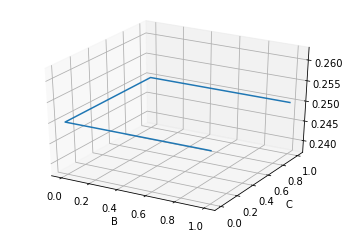

In [67]:
def conj_scenario(U,V):
    return V[0] and V[1] and V[2]
#Takes a lst of F/T and converts to 0/1 resp.
def decode(lst):
    return [1 if (i == True) else 0 for i in lst]
A_inf = []
B_vals = []
C_vals = []
potential_val = [(True,True),(False,True),(False,False),(True,False)]
U = [True for i in range(3)]
R = [(False,True) for i in range(4)]
F = [None for i in range(3)] + [conj_scenario]
for tup in potential_val:
    V = [True,tup[0],tup[1],conj_scenario(U,[True,tup[0],tup[1],None])]
    model = Causal_Model(U,V,R,F)
    A_inf.append(model.influence([True],[0],1,conj_scenario))
    B_vals.append(tup[0])
    C_vals.append(tup[1])
    
A_inf = np.asarray(A_inf)
print(B_vals)
B_vals = np.asarray(decode(B_vals))
print(B_vals)
C_vals = np.asarray(decode(C_vals))
fig = plt.figure()
ax = fig.gca(projection='3d')
ax.plot(B_vals,C_vals,A_inf)
ax.set_xlabel('B')
ax.set_ylabel('C')
plt.show()

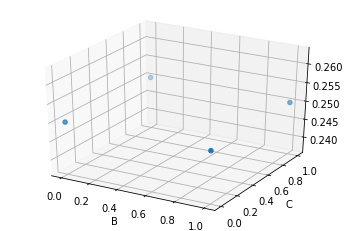

In [68]:
def disj_scenario(U,V):
    return V[0] or V[1] or V[2]
A_inf = []
B_vals = []
C_vals = []
potential_val = [(True,True),(False,True),(False,False),(True,False)]
U = [True for i in range(3)]
R = [(False,True) for i in range(4)]
F = [None for i in range(3)] + [disj_scenario]
for tup in potential_val:
    V = [True,tup[0],tup[1],disj_scenario(U,[True,tup[0],tup[1],None])]
    model = Causal_Model(U,V,R,F)
    A_inf.append(model.influence([True],[0],1,disj_scenario))
    B_vals.append(tup[0])
    C_vals.append(tup[1])
    
A_inf = np.asarray(A_inf)
B_vals = np.asarray(decode(B_vals))
C_vals = np.asarray(decode(C_vals))
fig = plt.figure()
ax = fig.gca(projection='3d')
ax.scatter(B_vals,C_vals,A_inf)
ax.set_xlabel('B')
ax.set_ylabel('C')
plt.show()

### Plotting Responsibility

(False b/c of AC2)
(False b/c of AC2)
(False b/c of AC2)


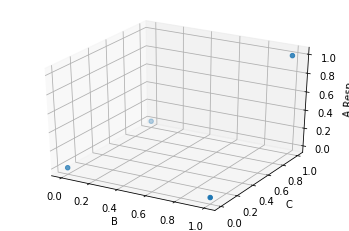

In [69]:
def conj_scenario(U,V):
    return V[0] and V[1] and V[2]
#Takes a lst of F/T and converts to 0/1 resp.
def decode(lst):
    return [1 if (i == True) else 0 for i in lst]
A_resp = []
B_vals = []
C_vals = []
potential_val = [(True,True),(False,True),(False,False),(True,False)]
U = [True for i in range(3)]
R = [(False,True) for i in range(4)]
F = [None for i in range(3)] + [conj_scenario]
for tup in potential_val:
    outcome = conj_scenario(U,[True,tup[0],tup[1],None])
    V = [True,tup[0],tup[1],outcome]
    model = Causal_Model(U,V,R,F)
    A_resp.append(model.responsibility([True],[0],outcome,conj_scenario))
    B_vals.append(tup[0])
    C_vals.append(tup[1])
    
A_resp = np.asarray(A_resp)
B_vals = np.asarray(decode(B_vals))
C_vals = np.asarray(decode(C_vals))
fig = plt.figure()
ax = fig.gca(projection='3d')
ax.scatter(B_vals,C_vals,A_resp)
ax.set_xlabel('B')
ax.set_ylabel('C')
ax.set_zlabel('A Resp.')
plt.show()

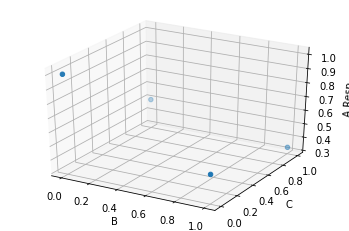

In [70]:
#Plotting disj scenario
A_resp = []
B_vals = []
C_vals = []
for tup in potential_val:
    outcome = disj_scenario(U,[True,tup[0],tup[1],None])
    V = [True,tup[0],tup[1],outcome]
    model = Causal_Model(U,V,R,F)
    A_resp.append(model.responsibility([True],[0],outcome,disj_scenario))
    B_vals.append(tup[0])
    C_vals.append(tup[1])
A_resp = np.asarray(A_resp)
B_vals = np.asarray(decode(B_vals))
C_vals = np.asarray(decode(C_vals))
fig = plt.figure()
ax = fig.gca(projection='3d')
ax.scatter(B_vals,C_vals,A_resp)
ax.set_xlabel('B')
ax.set_ylabel('C')
ax.set_zlabel('A Resp.')
plt.show()

### Creating a function to plot
#### Assuming boolean valued var

In [71]:
#z_val corresps to which function to plot: 0 = resp of X, 1 = influence of X, 2 = adj_resp of X, 3 = adj_resp_2 of X
#Assumes Y is length 2 corresp to the other var we want to measure X's z_val relative to 
#Plots
#Returns list of all points (B_val,C_val,Z_val)
def plot(X,X_indices,Y_indices,U,V,R,F,outcome_func,num_outcome,z_val):
    decode = lambda lst: [1 if (i == True) else 0 for i in lst]
    potential_val = [(True,True),(False,True),(False,False),(True,False)]
    B_vals = []
    C_vals = []
    Z_vals = []
    fig = plt.figure()
    ax = fig.gca(projection='3d')
    for tup in potential_val:
        V = V_given_set(V,X,X_indices)
        B_vals.append(tup[0])
        C_vals.append(tup[1])
        V = V_given_set(V,[tup[0]],[Y_indices[0]])
        V = V_given_set(V,[tup[1]],[Y_indices[1]])
        outcome = outcome_func(U,V)
        V = V_given_set(V,[outcome],[len(V)-num_outcome])
        curr_model = Causal_Model(U,V,R,F)
        if z_val == 0:
            ax.set_zlabel('A Resp.')
            Z_vals.append(curr_model.responsibility(X,X_indices,outcome,outcome_func))
        elif z_val == 1:
            ax.set_zlabel('A Influence.')
            Z_vals.append(curr_model.influence(X,X_indices,num_outcome,outcome_func))
        elif z_val == 2:
            ax.set_zlabel('Adj Resp of A.')
            Z_vals.append(curr_model.adj_responsibility(X,X_indices,num_outcome,outcome,outcome_func))
        else:
            ax.set_zlabel('Adj Resp #2 of A.')
            Z_vals.append(curr_model.adj_responsibility_2(X,X_indices,num_outcome,outcome,outcome_func))
    Z_vals = np.asarray(Z_vals)
    B_vals = np.asarray(decode(B_vals))
    C_vals = np.asarray(decode(C_vals))
    ax.scatter(B_vals,C_vals,A_inf)
    ax.set_xlabel('B')
    ax.set_ylabel('C')
    plt.show()
    return [(B_vals[i],C_vals[i],Z_vals[i]) for i in range(len(B_vals))]


(False b/c of AC2)
(False b/c of AC2)
(False b/c of AC2)


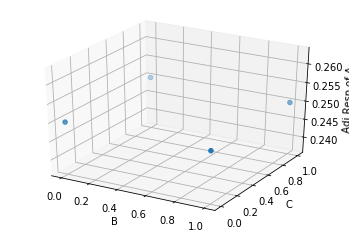

[(1, 1, 0.25), (0, 1, 0.0), (0, 0, 0.0), (1, 0, 0.0)]

In [72]:
plot([True],[0],[1,2],[True for i in range (3)], [True for i in range(4)], [(False,True) for i in range(4)],
    [None for i in range(3)] + [conj_scenario],conj_scenario,1,2)

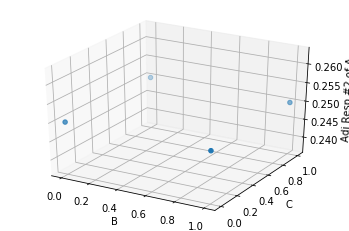

[(1, 1, 0), (0, 1, None), (0, 0, None), (1, 0, None)]

In [73]:
plot([True],[0],[1,2],[True for i in range (3)], [True for i in range(4)], [(False,True) for i in range(4)],
    [None for i in range(3)] + [conj_scenario],conj_scenario,1,3)

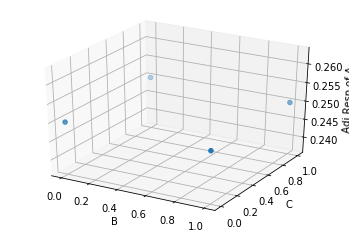

[(1, 1, 0.08333333333333333), (0, 1, 0.125), (0, 0, 0.25), (1, 0, 0.125)]

In [74]:
plot([True],[0],[1,2],[True for i in range (3)], [True for i in range(4)], [(False,True) for i in range(4)],
    [None for i in range(3)] + [disj_scenario],disj_scenario,1,2)

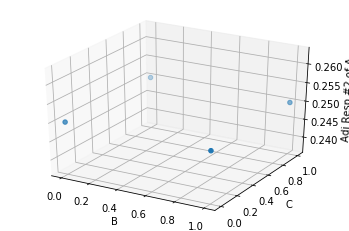

[(1, 1, 0.5), (0, 1, 0.25), (0, 0, 0.0), (1, 0, 0.25)]

In [75]:
plot([True],[0],[1,2],[True for i in range (3)], [True for i in range(4)], [(False,True) for i in range(4)],
    [None for i in range(3)] + [disj_scenario],disj_scenario,1,3)

### Testing Electoral Model

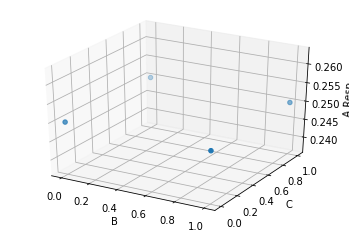

[(1, 1, 0.5), (0, 1, 1.0), (0, 0, 1.0), (1, 0, 1.0)]

In [76]:
#U = some relevant exogenous var(e.g. every state's election is not rigged)
# V = the votes for each state, following EC_votes ordering and upholding scenario (Dem win by 1 vote)
# Assumes: True = Vote for Dem. ; False = Vote for Rep.
U = [True for i in range(11)]
V = [True,False,True,False,True,False,True,False,False,False,True,True,False]
R = [(False,True) for i in range(len(V))]
#Counts the votes and excludes last 2 elem of V which corresp to Dem_win, Rep_win
def dem_win(U,V):
    true_vote_idx = [i for i in range(len(V[0:-2])) if V[i] == True]
    num_votes = sum([EC_votes[i] for i in true_vote_idx])
    return num_votes > (int(sum(EC_votes)/2))
F = [None for i in range(len(U))] + [dem_win, not dem_win]
X = [True]
X_indices = [0]
Y_indices = [1,3]
num_outcome = 2
outcome_func = dem_win
z_val = 0
plot(X,X_indices,Y_indices,U,V,R,F,outcome_func,num_outcome,z_val)

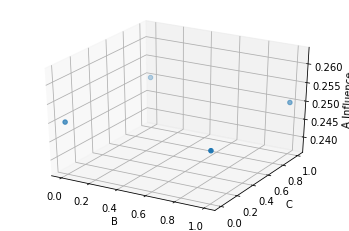

[(1, 1, 0.53515625),
 (0, 1, 0.53515625),
 (0, 0, 0.53515625),
 (1, 0, 0.53515625)]

In [77]:
z_val = 1
plot(X,X_indices,Y_indices,U,V,R,F,outcome_func,num_outcome,z_val)

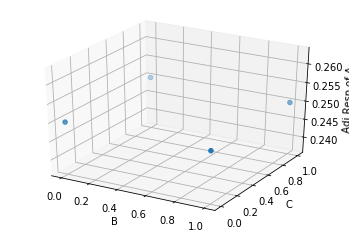

[(1, 1, 0.267578125),
 (0, 1, 0.53515625),
 (0, 0, 0.53515625),
 (1, 0, 0.53515625)]

In [78]:
z_val = 2
plot(X,X_indices,Y_indices,U,V,R,F,outcome_func,num_outcome,z_val)

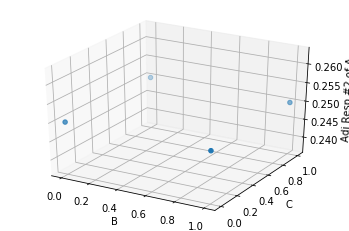

[(1, 1, 0.31640625), (0, 1, 0.0), (0, 0, 0.0), (1, 0, 0.0)]

In [79]:
z_val = 3
plot(X,X_indices,Y_indices,U,V,R,F,outcome_func,num_outcome,z_val)